# Problema: otimizar o consumo de energia em três bairros de Tetuan, utilizando dados climáticos e históricos para entender padrões e prever a demanda futura. O objetivo é:

1. Identificar tendências e padrões de consumo.
2. Desenvolver um modelo básico de previsão para ajudar no planejamento.

* Importação das bibliotecas e carregamento do dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import calendar
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv("power consumption.csv")
df

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3
0,01-01-2017 00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,01-01-2017 00:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,01-01-2017 00:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,01-01-2017 00:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,01-01-2017 00:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


* Tratamento de dados:

In [3]:
# Vamos padronizar as datas e alterar o formato da coluna DateTime:
df['DateTime'] = df['DateTime'].str.replace(r'[/.]', '-', regex=True)
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Vamos agrupar os dados por mês:
df_mensal = df.copy()
df_mensal.set_index('DateTime', inplace=True)
df_mensal = df_mensal.resample('M').sum()

# Vamos agrupar os dados por dias:
df_dias = df.copy()
df_dias.set_index('DateTime', inplace=True)
df_dias = df_dias.resample('D').sum()

# Vamos alterar o nome das colunas e colocar os registros no indice:
df = df.rename(columns={'Temperature': 'Temperatura', 'Humidity': 'Umidade', 'Wind Speed': 'Velocidade_Vento',
                        'general diffuse flows': 'fluxos_difusos_gerais', 'diffuse flows': 'fluxos_difusos',
                        'Zone 1': 'Bairro1', 'Zone 2  ': 'Bairro2', 'Zone 3  ': 'Bairro3'})
df.set_index('DateTime', inplace=True)

# Alguns dados de temperatura parecem estar com uma formatação um pouco diferente do restante. 
# Podemos perceber no inicio do nosso DataFrame que a temperatura é de 6.559 c°, o que pode querer significar 6.55 c°. 
# Vamos arrumar isso:
df['Temperatura'] = df['Temperatura'].round(2)

# Vamos tratar os DF's que contém os registros por dia e por mês:

#Renomeando colunas:
df_mensal = df_mensal.rename(columns={'Temperature': 'Temperatura','Humidity': 'Umidade', 'Wind Speed': 'Velocidade_Vento',
                        'general diffuse flows': 'fluxos_difusos_gerais', 'diffuse flows': 'fluxos_difusos',
                        'Zone 1': 'Bairro1', 'Zone 2  ': 'Bairro2', 'Zone 3  ': 'Bairro3'})

#Arredondando valores de consumo nos bairros:
df_mensal['Bairro1'] = df_mensal['Bairro1'].round(1)
df_mensal['Bairro2'] = df_mensal['Bairro2'].round(1)
df_mensal['Bairro3'] = df_mensal['Bairro3'].round(1)

#Os registros de temperatura foram todos somados, vamos tirar a média da temperatura do mês registrado:
df_mensal['dia_do_mes'] = df_mensal.index.to_series().dt.month.apply(lambda m: calendar.monthrange(df_mensal.index.year[0], m)[1])
df_mensal['Registros_Mes'] = df_mensal['dia_do_mes'] * 144
df_mensal['Temperatura'] = df_mensal['Temperatura'] / df_mensal['Registros_Mes']
df_mensal['Temperatura'] = df_mensal['Temperatura'].round(2)

# Vamos repitir o mesmo processo para a umidade:
df_mensal['Umidade'] = df_mensal['Umidade'] / df_mensal['Registros_Mes']
df_mensal['Umidade'] = df_mensal['Umidade'].round(2)

#Renomeando colunas:
df_dias = df_dias.rename(columns={'Temperature': 'Temperatura','Humidity': 'Umidade', 'Wind Speed': 'Velocidade_Vento',
                        'general diffuse flows': 'fluxos_difusos_gerais', 'diffuse flows': 'fluxos_difusos',
                        'Zone 1': 'Bairro1', 'Zone 2  ': 'Bairro2', 'Zone 3  ': 'Bairro3'})

#Arredondando valores de consumo nos bairros:
df_dias['Bairro1'] = df_dias['Bairro1'].round(1)
df_dias['Bairro2'] = df_dias['Bairro2'].round(1)
df_dias['Bairro3'] = df_dias['Bairro3'].round(1)

# Criando uma coluna para os regsitros diarios:
df_dias['Registros_diarios'] = 144
df_dias['Temperatura'] = df_dias['Temperatura'] / df_dias['Registros_diarios']
df_dias['Temperatura'] = df_dias['Temperatura'].round(2)

# Repetindo o processo para umidade:
df_dias['Umidade'] = df_dias['Umidade'] / df_dias['Registros_diarios']
df_dias['Umidade'] = df_dias['Umidade'].round(2)

In [4]:
df

,Temperatura,Umidade,Velocidade_Vento,fluxos_difusos_gerais,fluxos_difusos,Bairro1,Bairro2,Bairro3
DateTime,,,,,,,,
2017-01-01 00:00:00,6.56,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.41,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.31,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.12,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.92,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.01,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.95,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.90,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259


In [5]:
df_dias

,Temperatura,Umidade,Velocidade_Vento,fluxos_difusos_gerais,fluxos_difusos,Bairro1,Bairro2,Bairro3,Registros_diarios
DateTime,,,,,,,,,
2017-01-01,9.68,68.52,45.381,17480.271,3743.125,4098993.4,2554241.9,2573106.5,144
2017-01-02,12.48,71.46,11.025,17338.246,3920.747,4157207.1,2816312.5,2566189.9,144
2017-01-03,12.10,74.98,11.047,17378.786,4114.751,4400992.4,2888246.8,2537395.7,144
2017-01-04,10.51,75.46,11.868,17706.142,4151.120,4419335.7,2894699.1,2545012.0,144
2017-01-05,10.87,71.04,12.081,17099.980,4282.767,4435619.2,2884887.5,2543641.4,144
...,...,...,...,...,...,...,...,...,...
2017-12-26,11.62,69.07,11.961,15384.483,7309.496,4321940.7,3565008.9,1640977.7,144
2017-12-27,15.23,59.45,11.812,13808.257,6005.529,4315242.6,3608277.4,1655752.2,144
2017-12-28,13.66,62.84,11.715,16217.303,4350.148,4358448.7,3540276.2,1608051.9,144


In [6]:
df_mensal

,Temperatura,Umidade,Velocidade_Vento,fluxos_difusos_gerais,fluxos_difusos,Bairro1,Bairro2,Bairro3,dia_do_mes,Registros_Mes
DateTime,,,,,,,,,,
2017-01-31,12.74,68.29,3160.188,461324.919,306620.612,138529051.1,86576801.2,79218569.6,31,4464
2017-02-28,12.64,66.55,4421.063,507100.368,369443.836,124934558.6,75752381.8,69894728.7,28,4032
2017-03-31,14.58,71.10,4491.629,808390.034,419543.474,139076658.4,82396232.9,75654470.3,31,4464
2017-04-30,16.44,75.24,968.840,688604.054,364188.117,134653398.7,76178734.8,80322484.4,30,4320
2017-05-31,20.29,68.71,10259.483,1221646.470,549288.031,144615784.9,89178613.0,78660594.7,31,4464
2017-06-30,22.14,68.64,6768.098,1208067.715,448221.285,149495936.4,89298411.6,88261667.4,30,4320
2017-07-31,27.20,57.51,20671.076,1311706.409,335724.708,159952055.3,107796167.1,125858512.5,31,4464
2017-08-31,25.75,66.05,20243.050,1017931.929,300874.460,162646686.3,110065350.8,110032666.1,31,4464
2017-09-30,22.64,66.85,12727.628,869228.489,210072.405,144273663.7,87179467.4,64466490.7,30,4320


# Análise exploratória dos dados:

* Vamos fazer uma descrição dos dados de cada DataFrame.

In [7]:
df.describe().round(2)

,Temperatura,Umidade,Velocidade_Vento,fluxos_difusos_gerais,fluxos_difusos,Bairro1,Bairro2,Bairro3
count,52416.00,52416.00,52416.00,52416.00,52416.00,52416.00,52416.00,52416.00
mean,18.81,68.26,1.96,182.70,75.03,32344.97,21042.51,17835.41
std,5.82,15.55,2.35,264.40,124.21,7130.56,5201.47,6622.17
min,3.25,11.34,0.05,0.00,0.01,13895.70,8560.08,5935.17
25%,14.41,58.31,0.08,0.06,0.12,26310.67,16980.77,13129.33
50%,18.78,69.86,0.09,5.04,4.46,32265.92,20823.17,16415.12
75%,22.89,81.40,4.92,319.60,101.00,37309.02,24713.72,21624.10
max,40.01,94.80,6.48,1163.00,936.00,52204.40,37408.86,47598.33


In [8]:
df_mensal.describe().round(2)

,Temperatura,Umidade,Velocidade_Vento,fluxos_difusos_gerais,fluxos_difusos,Bairro1,Bairro2,Bairro3,dia_do_mes,Registros_Mes
count,12.00,12.00,12.00,12.00,12.00,1.200000e+01,1.200000e+01,1.200000e+01,12.00,12.00
mean,18.72,68.08,8559.05,798018.81,327722.40,1.412828e+08,9.191368e+07,7.790505e+07,30.42,4380.00
std,5.11,4.22,6794.49,324534.69,112695.32,1.262161e+07,1.144829e+07,2.227304e+07,0.90,129.65
min,12.64,57.51,968.84,428796.28,147866.88,1.249346e+08,7.575238e+07,4.771356e+07,28.00,4032.00
25%,14.15,66.77,4105.84,518927.18,256089.80,1.323362e+08,8.553166e+07,6.315260e+07,30.00,4320.00
50%,18.56,68.46,6111.34,748497.04,321172.66,1.416752e+08,8.923851e+07,7.715753e+07,31.00,4464.00
75%,22.26,69.96,12525.25,1065465.88,381968.75,1.472810e+08,1.008755e+08,8.230728e+07,31.00,4464.00
max,27.20,75.24,20671.08,1311706.41,549288.03,1.626467e+08,1.100654e+08,1.258585e+08,31.00,4464.00


In [9]:
df_dias.describe().round(2)

,Temperatura,Umidade,Velocidade_Vento,fluxos_difusos_gerais,fluxos_difusos,Bairro1,Bairro2,Bairro3,Registros_diarios
count,364.00,364.00,364.00,364.00,364.00,364.00,364.00,364.00,364.0
mean,18.81,68.26,282.17,26308.31,10804.04,4657675.76,3030121.31,2568298.50,144.0
std,5.20,11.51,317.34,12407.37,5570.26,384388.99,390032.79,706250.98,0.0
min,8.63,29.36,9.28,3808.07,2772.06,3855098.70,2128190.20,1516408.20,144.0
25%,14.20,60.03,11.60,16280.32,6421.76,4396490.75,2742698.82,2054210.15,144.0
50%,19.08,70.27,34.10,23947.06,9743.04,4596623.20,2996259.05,2508705.55,144.0
75%,22.87,76.94,706.63,38116.87,14047.38,4910511.70,3361585.30,2726402.90,144.0
max,32.43,89.59,709.99,48249.46,30115.33,5577623.40,4083053.20,4708830.10,144.0


# 1. Vamos plotar dois gráficos, um para visualizar qual mês tem a maior e a menor demanda em cada bairro e um para ver qual dia da semana tem maior e menor demanda em cada bairro. Vamos ver também a evolução do consumo de energia elétrica.

* Maior e menor consumo de energia elétrica em cada bairro por mês:

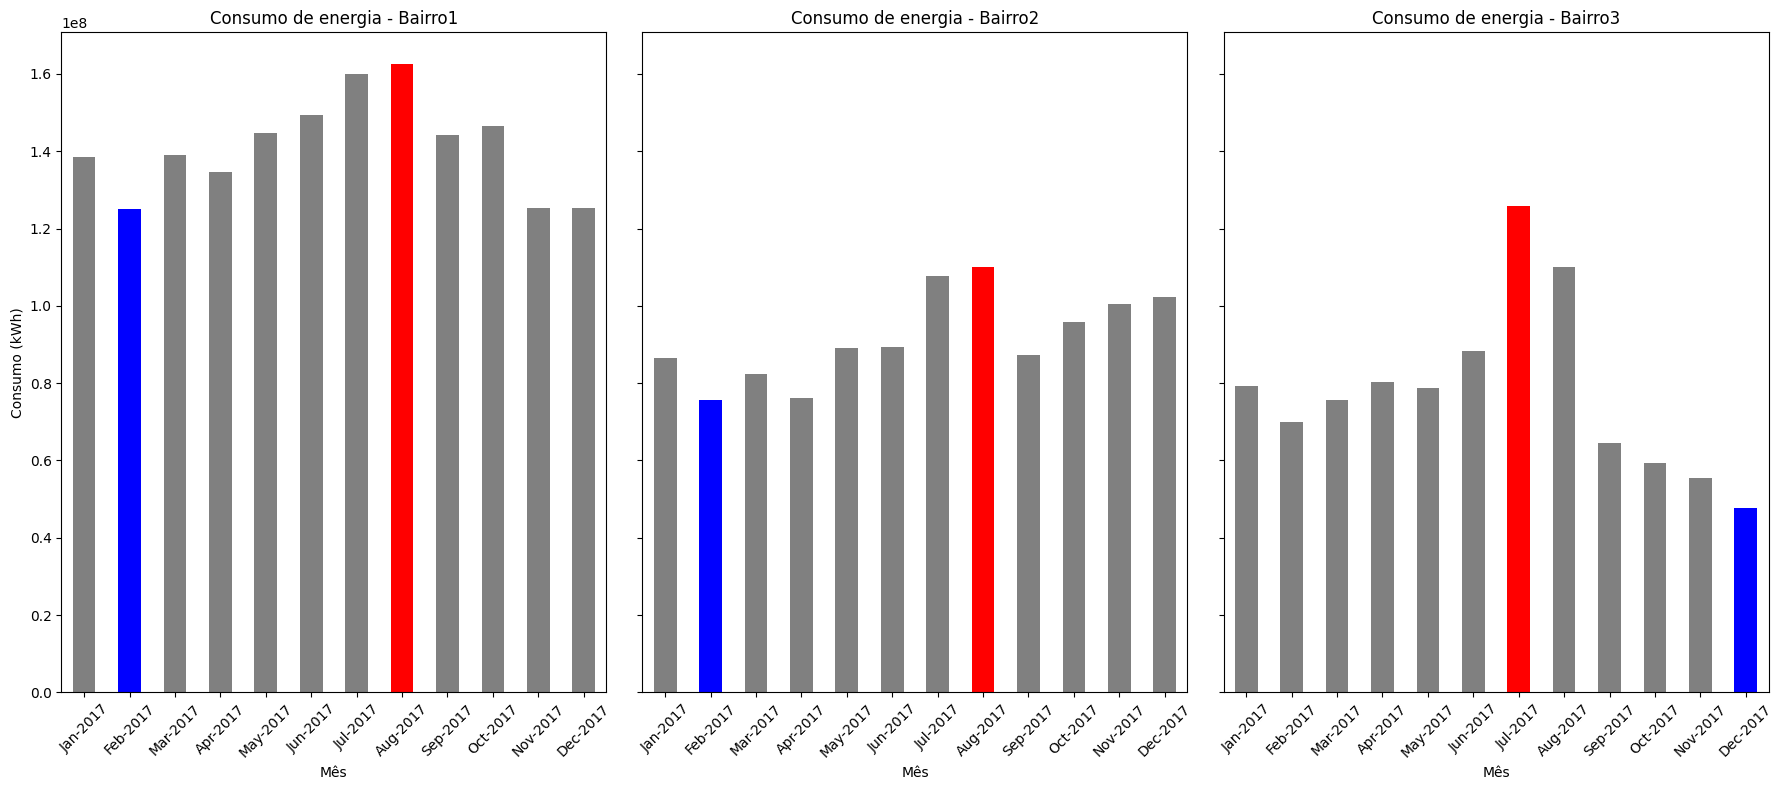

In [10]:
# Lista dos bairros:
bairros = ['Bairro1', 'Bairro2', 'Bairro3']

# Tamanho da figura:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8), sharey=True)

# Itera por cada bairro e criar um subplot:
for i, bairro in enumerate(bairros):
    ax = axes[i]

    # Identifica o mês com maior e menor demanda:
    max_val = df_mensal[bairro].max()
    min_val = df_mensal[bairro].min()

    # Destaque para os meses com maior e menor demanda:
    colors = ['red' if x == max_val else 'blue' if x == min_val else 'gray' for x in df_mensal[bairro]]

    # Plotando o gráfico de barras:
    df_mensal[bairro].plot(kind='bar', color=colors, ax=ax, legend=False)

    # Titulos e legendas:
    ax.set_title(f"Consumo de energia - {bairro}")
    ax.set_xlabel('Mês')
    ax.set_ylabel("Consumo (kWh)" if i == 0 else "")
    ax.set_xticks(range(len(df_mensal.index)))
    ax.set_xticklabels(df_mensal.index.strftime('%b-%Y'), rotation=45)

# Ajuste nos espaços entre os gráficos:
plt.tight_layout()
plt.show()

* Maior e menor consumo de energia elétrica diario por mês em cada bairro:

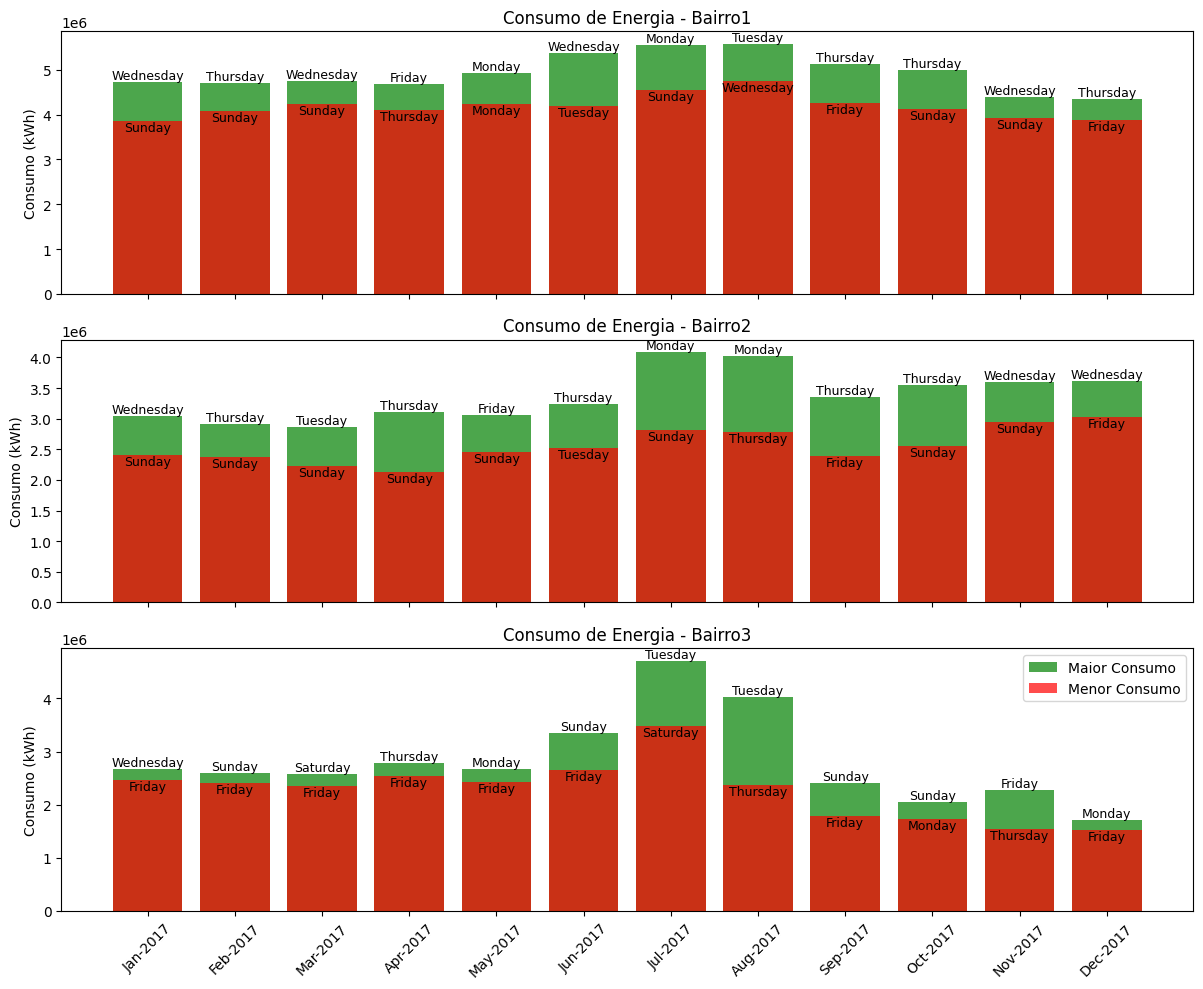

In [11]:
# Garantir que o índice de datas está no formato datetime
df_dias.index = pd.to_datetime(df_dias.index)

# Criar colunas auxiliares para ordenação
df_dias["Dia_da_Semana"] = df_dias.index.day_name()  # Nome do dia da semana
df_dias["Mês_Ano"] = df_dias.index.strftime('%b-%Y')  # Nome do mês para exibição
df_dias["Ordem_Mês_Ano"] = df_dias.index.to_period("M")  # Período para ordenação correta

# Criar a figura e os eixos
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
bairros = ["Bairro1", "Bairro2", "Bairro3"]
cores = {"max": "green", "min": "red"}

# Iterar sobre os bairros
for i, bairro in enumerate(bairros):
    ax = axes[i]  

    # Encontrar dias de maior e menor consumo
    maximos = df_dias.loc[df_dias.groupby("Mês_Ano")[bairro].idxmax(), ["Mês_Ano", "Dia_da_Semana", bairro]]
    minimos = df_dias.loc[df_dias.groupby("Mês_Ano")[bairro].idxmin(), ["Mês_Ano", "Dia_da_Semana", bairro]]

    # Adicionar coluna de ordenação
    maximos["Ordem_Mês_Ano"] = pd.to_datetime(maximos["Mês_Ano"], format='%b-%Y')
    minimos["Ordem_Mês_Ano"] = pd.to_datetime(minimos["Mês_Ano"], format='%b-%Y')

    # Renomear colunas
    maximos = maximos.rename(columns={"Dia_da_Semana": "Dia_Max", bairro: "Consumo_Max"})
    minimos = minimos.rename(columns={"Dia_da_Semana": "Dia_Min", bairro: "Consumo_Min"})

    # Criar DataFrame combinado e ordenar corretamente
    df_plot = pd.merge(maximos, minimos, on=["Mês_Ano", "Ordem_Mês_Ano"]).sort_values("Ordem_Mês_Ano")

    # Plotar os valores
    ax.bar(df_plot["Mês_Ano"], df_plot["Consumo_Max"], color=cores["max"], label="Maior Consumo", alpha=0.7)
    ax.bar(df_plot["Mês_Ano"], df_plot["Consumo_Min"], color=cores["min"], label="Menor Consumo", alpha=0.7)

    # Configuração do eixo
    ax.set_title(f"Consumo de Energia - {bairro}")
    ax.set_ylabel("Consumo (kWh)")

    # Exibir os dias nos rótulos das barras
    for j in range(len(df_plot)):
        ax.text(j, df_plot["Consumo_Max"].iloc[j], df_plot["Dia_Max"].iloc[j], ha='center', va='bottom', fontsize=9, color='black')
        ax.text(j, df_plot["Consumo_Min"].iloc[j], df_plot["Dia_Min"].iloc[j], ha='center', va='top', fontsize=9, color='black')

# Configuração do eixo X
axes[-1].set_xticks(range(len(df_plot["Mês_Ano"])))  
axes[-1].set_xticklabels(df_plot["Mês_Ano"], rotation=45)

# Legenda e layout
plt.legend()
plt.tight_layout()
plt.show()


* Evolução do consumo de energia elétrica:

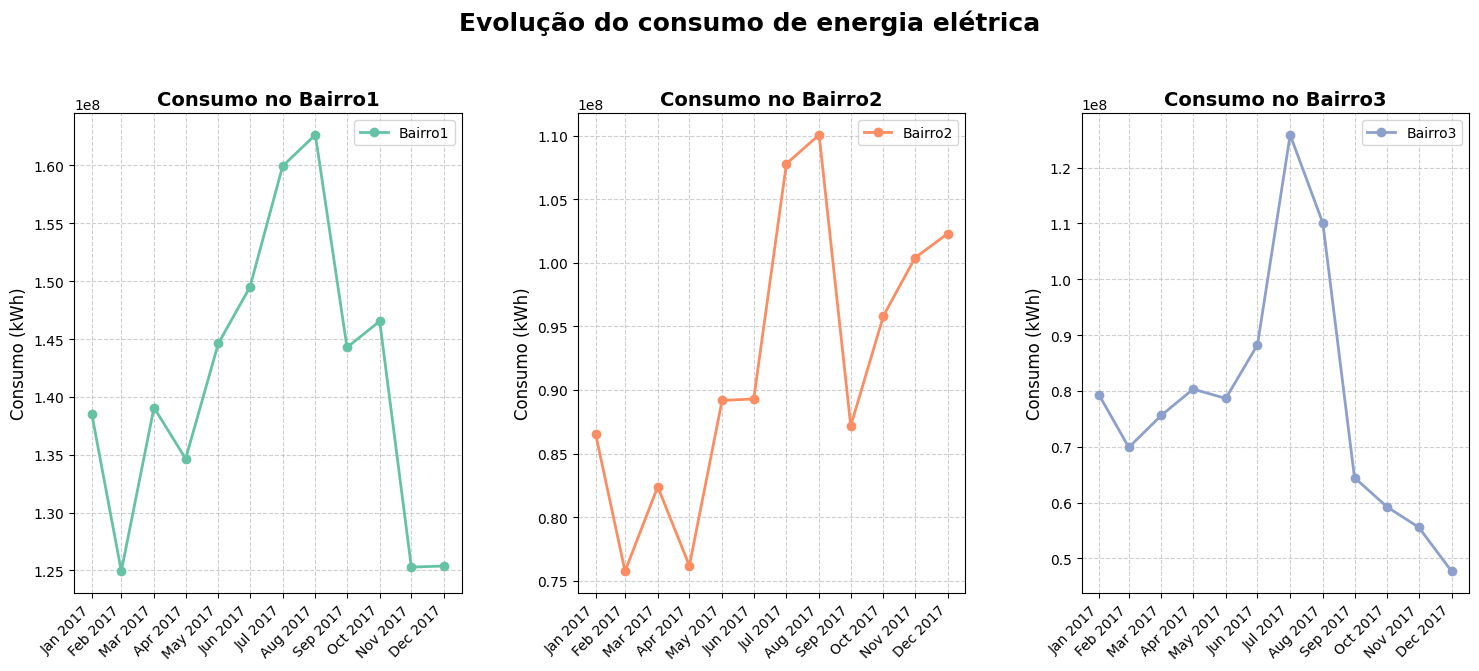

In [12]:
bairros = ['Bairro1', 'Bairro2', 'Bairro3']

# Tamanho da figura:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8),sharex=True)
plt.suptitle('Evolução do consumo de energia elétrica', fontsize=18, fontweight='bold')

# Formatando as datas para exibir todos os meses no eixo X:
labels_formatadas = df_mensal.index.strftime('%b %Y')  
posicoes_x = range(len(df_mensal.index))  # Criando posições para cada rótulo no eixo X

# Iteração por cada bairro:
for i, bairro in enumerate(bairros):
    ax = axes[i]
    ax.plot(df_mensal.index, df_mensal[bairro], marker='o', linestyle='-', 
            markersize=6, linewidth=2, label=bairro, color=plt.cm.Set2(i))
    
    ax.set_title(f'Consumo no {bairro}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Consumo (kWh)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Ajustando o eixo X para mostrar todos os meses
    ax.set_xticks(df_mensal.index)
    ax.set_xticklabels(labels_formatadas, rotation=45, ha='right', fontsize=10)

# Ajustando espaçamento entre gráficos
plt.subplots_adjust(top=0.85, bottom=0.25, wspace=0.3)

plt.show()
    

# Correlação climática.

In [13]:
import seaborn as sns

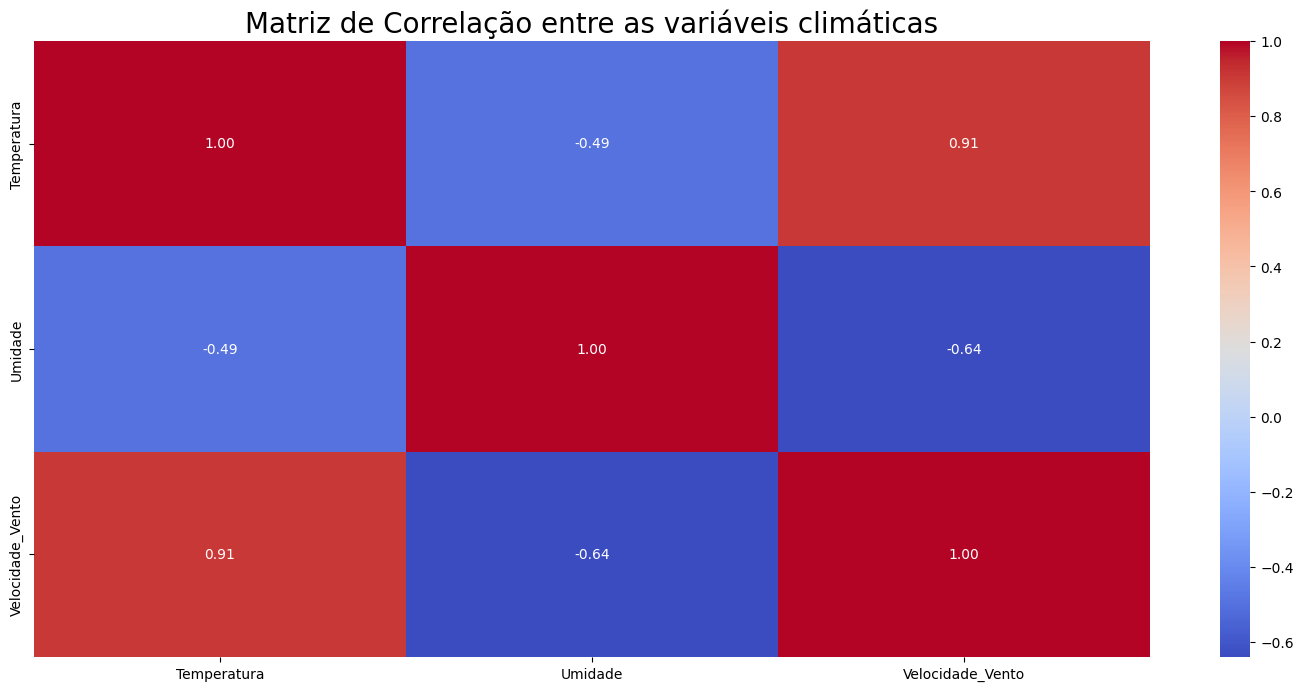

In [14]:
# Calculando a matriz de correlação:
Matriz_Correlacao = df_mensal[['Temperatura', 'Umidade', 'Velocidade_Vento']].corr()

# Plotando a correlação em heatmap:
plt.figure(figsize=(18,8))
sns.heatmap(Matriz_Correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre as variáveis climáticas', fontsize=20)
plt.show()

# Previsão da demanda de energia elétrica.

In [15]:
# Criamos um Dataframe somente com o consumo mensal dos bairros:  
df_mensal_bairros = df_mensal[['Bairro1', 'Bairro2', 'Bairro3']].copy()
df_mensal_bairros

,Bairro1,Bairro2,Bairro3
DateTime,,,
2017-01-31,138529051.1,86576801.2,79218569.6
2017-02-28,124934558.6,75752381.8,69894728.7
2017-03-31,139076658.4,82396232.9,75654470.3
2017-04-30,134653398.7,76178734.8,80322484.4
2017-05-31,144615784.9,89178613.0,78660594.7
2017-06-30,149495936.4,89298411.6,88261667.4
2017-07-31,159952055.3,107796167.1,125858512.5
2017-08-31,162646686.3,110065350.8,110032666.1
2017-09-30,144273663.7,87179467.4,64466490.7


* Fazendo a previsão da demanda e plotando a demanda futura para cada bairro:


Previsões para Bairro1:
  Mês 13: 141817197 unidades
  Mês 14: 141899407 unidades
  Mês 15: 141981617 unidades
  Mês 16: 142063827 unidades
  Mês 17: 142146037 unidades
  Mês 18: 142228247 unidades
  Mês 19: 142310457 unidades
  Mês 20: 142392667 unidades
  Mês 21: 142474877 unidades
  Mês 22: 142557087 unidades
  Mês 23: 142639297 unidades
  Mês 24: 142721507 unidades


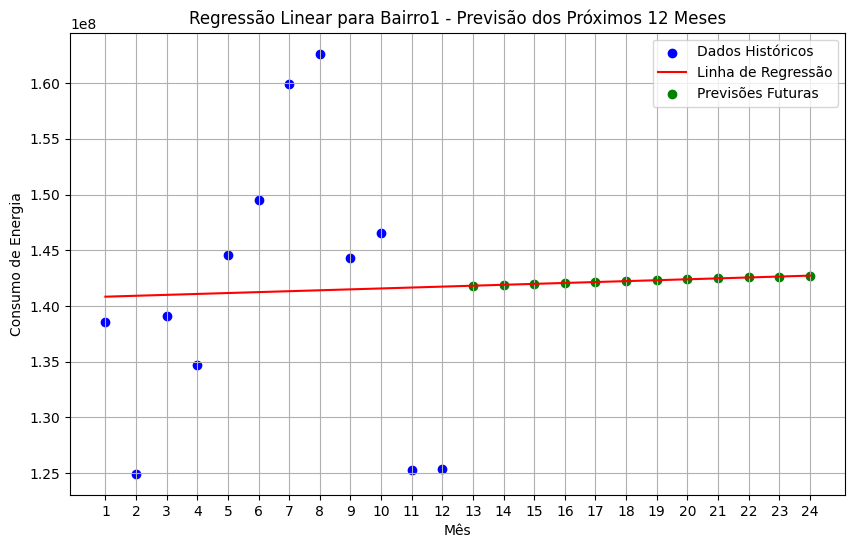


Previsões para Bairro2:
  Mês 13: 106120174 unidades
  Mês 14: 108305788 unidades
  Mês 15: 110491403 unidades
  Mês 16: 112677017 unidades
  Mês 17: 114862632 unidades
  Mês 18: 117048246 unidades
  Mês 19: 119233861 unidades
  Mês 20: 121419475 unidades
  Mês 21: 123605090 unidades
  Mês 22: 125790704 unidades
  Mês 23: 127976319 unidades
  Mês 24: 130161933 unidades


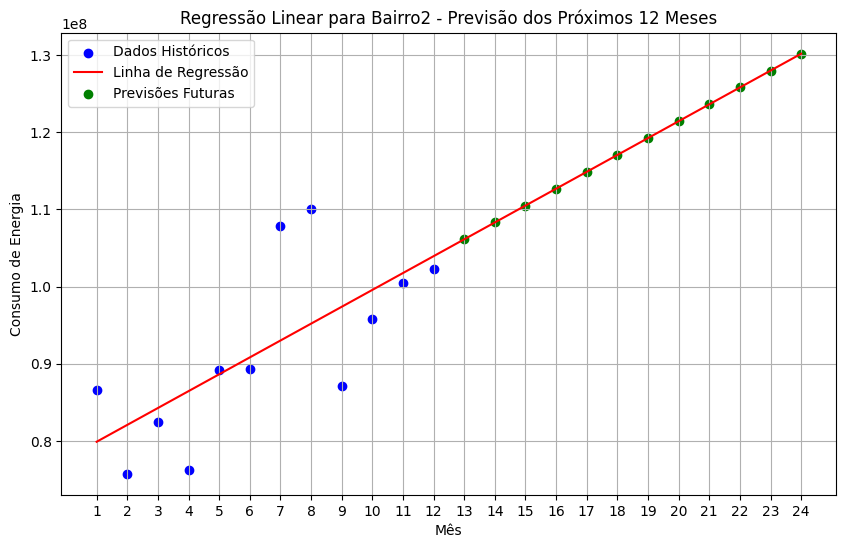


Previsões para Bairro3:
  Mês 13: 65673565 unidades
  Mês 14: 63791797 unidades
  Mês 15: 61910030 unidades
  Mês 16: 60028262 unidades
  Mês 17: 58146495 unidades
  Mês 18: 56264727 unidades
  Mês 19: 54382959 unidades
  Mês 20: 52501192 unidades
  Mês 21: 50619424 unidades
  Mês 22: 48737657 unidades
  Mês 23: 46855889 unidades
  Mês 24: 44974121 unidades


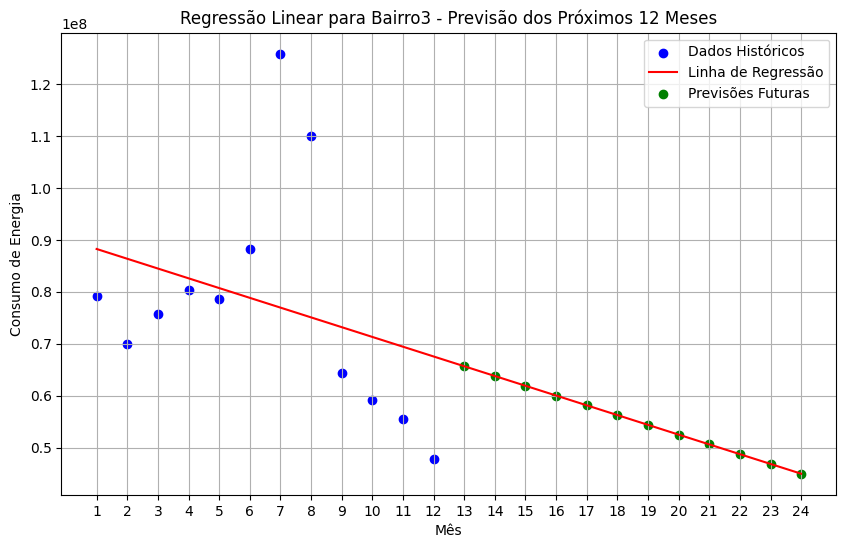

In [16]:
# números de mês de 1 a 12 para os dados históricos:
X_hist = np.arange(1, 13).reshape(-1,1)

bairros = ['Bairro1', 'Bairro2', 'Bairro3']

for bairro in bairros:
    # Extraindo os dados históricos para o bairro:
    y_hist = df_mensal_bairros[bairro].values

    # Criar e ajustar o modelo de regressão linear com os 12 meses históricos:
    modelo = LinearRegression()
    modelo.fit(X_hist, y_hist)

    # previsão para os próximos 12 meses(meses: 13 à 24):
    X_future = np.arange(13,25).reshape(-1,1)
    previsoes_futuro = modelo.predict(X_future)

    # Para uma visualização completa, podemos calcular a linha de regressão para meses 1 a 24:
    X_total = np.arange(1, 25).reshape(-1,1)
    previsoes_total = modelo.predict(X_total)

    # Exibir as previsões para os próximos 12 meses
    print(f"\nPrevisões para {bairro}:")
    for mes, previsao in zip(np.arange(13, 25), previsoes_futuro):
        print(f"  Mês {mes}: {previsao:.0f} unidades")
    
    # Plotar os resultados para o bairro
    plt.figure(figsize=(10, 6))
    plt.scatter(X_hist, y_hist, color='blue', label='Dados Históricos')  # Dados históricos (meses 1 a 12)
    plt.plot(X_total, previsoes_total, color='red', label='Linha de Regressão')  # Linha ajustada para meses 1 a 24
    plt.scatter(X_future, previsoes_futuro, color='green', label='Previsões Futuras')  # Previsões para meses 13 a 24
    plt.xlabel('Mês')
    plt.ylabel('Consumo de Energia')
    plt.title(f'Regressão Linear para {bairro} - Previsão dos Próximos 12 Meses')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 25))  # Exibe os meses de 1 a 24 no eixo X
    plt.show()

